# Analysis on ResMaskNet FER method using Padova Data

## Lib Import

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Data preprocessing

In [3]:
# Directory
pred_dir = 'data/combined_results.csv'
clips_dir  = 'data/PEDFE_set_clips/'  
labels_dir = 'data/Supplemental_Material_T1.csv'

# load data to panda dataframe
labels = pd.read_csv(labels_dir)
predicted_data = pd.read_csv(pred_dir)

# emotion to lowercase for comparison
labels['Emotion'] = labels['Emotion'].str.lower()

# extract highest mean as predicted emotion
predicted_data['predicted_emotion'] = predicted_data.iloc[:, 1:].idxmax(axis=1).str.split('_').str[1]

# Merge actual and predicted data on 'PEDFE_code'
merged_data = pd.merge(labels, predicted_data, on='PEDFE_code')

# Create a column (pred) for binary prediction 
merged_data['pred'] = (merged_data['Emotion'] == merged_data['predicted_emotion']).astype(int)

# Select the columns to consider for the highest value
emotion_columns = ['mean_anger', 'mean_disgust', 'mean_fear', 'mean_happiness', 'mean_sadness', 'mean_surprise', 'mean_neutral']

# Create column (pred (%)) for predication confident (%)
merged_data['pred (%)'] = merged_data[emotion_columns].max(axis=1)

## Merged_data

In [4]:
# Select specified columns
selected_columns = [
    'PEDFE_code', 'Gender', 'Type', 'Mean_Intensity', 'Mean_Genuineness', 
    'Hit rate Emotion (%)', 'Emotion', 'predicted_emotion', 'pred (%)','pred'
]
print("merged_data\n", merged_data[selected_columns])

merged_data
      PEDFE_code Gender     Type  Mean_Intensity  Mean_Genuineness  \
0        1_dg_1      F  Genuine            2.94              2.12   
1        1_dg_2      F  Genuine            3.52              3.00   
2        1_dg_3      F  Genuine            5.92              4.96   
3        1_dg_4      F  Genuine            3.88              1.88   
4        1_dg_5      F  Genuine            3.94              1.30   
...         ...    ...      ...             ...               ...   
1451    57_tg_3      F  Genuine            2.67              2.62   
1452    57_tg_4      F  Genuine            4.00              2.42   
1453    57_ts_1      F    Posed            2.70             -0.26   
1454    57_ts_2      F    Posed            2.76             -1.91   
1455    57_ts_3      F    Posed            3.19             -1.58   

      Hit rate Emotion (%)  Emotion predicted_emotion  pred (%)  pred  
0                    78.79  disgust           disgust  0.521609     1  
1             

### Split Data to Genuine and Posed

In [5]:
genuine_data = merged_data[merged_data['Type'] == 'Genuine']
posed_data = merged_data[merged_data['Type'] == 'Posed']

## Correlation_matrix (Posed)

In [6]:
corr_1 = posed_data[['Mean_Intensity', 'Mean_Genuineness', 'Hit rate Emotion (%)', 'pred (%)']].corr()
print("Correlation Matrix\n",corr_1)

y_true = posed_data['Emotion']
y_pred = posed_data['predicted_emotion']
labels = posed_data['Emotion'].unique()

report_1 = classification_report(y_true, y_pred, labels=labels)
print("\nReport\n",report_1)

Correlation Matrix
                       Mean_Intensity  Mean_Genuineness  Hit rate Emotion (%)  \
Mean_Intensity              1.000000          0.003613              0.316514   
Mean_Genuineness            0.003613          1.000000             -0.074059   
Hit rate Emotion (%)        0.316514         -0.074059              1.000000   
pred (%)                   -0.052041          0.023482              0.183449   

                      pred (%)  
Mean_Intensity       -0.052041  
Mean_Genuineness      0.023482  
Hit rate Emotion (%)  0.183449  
pred (%)              1.000000  

Report
               precision    recall  f1-score   support

     disgust       0.70      0.41      0.52       149
   happiness       0.74      0.98      0.84       156
        fear       0.45      0.11      0.17        93
       anger       0.44      0.09      0.15        90
    surprise       0.68      0.46      0.55       131
     sadness       0.39      0.76      0.52       132

   micro avg       0.58  

## Correlation_matrix (Genuine)

In [7]:
corr_2 = genuine_data[['Mean_Intensity', 'Mean_Genuineness', 'Hit rate Emotion (%)', 'pred (%)']].corr()
print("Correlation Matrix\n",corr_2)

y_true = genuine_data['Emotion']
y_pred = genuine_data['predicted_emotion']
labels = genuine_data['Emotion'].unique()

report_2 = classification_report(y_true, y_pred, labels=labels)
print("\nReport\n",report_2)

Correlation Matrix
                       Mean_Intensity  Mean_Genuineness  Hit rate Emotion (%)  \
Mean_Intensity              1.000000          0.356923              0.540691   
Mean_Genuineness            0.356923          1.000000              0.214744   
Hit rate Emotion (%)        0.540691          0.214744              1.000000   
pred (%)                    0.155220          0.176916              0.261928   

                      pred (%)  
Mean_Intensity        0.155220  
Mean_Genuineness      0.176916  
Hit rate Emotion (%)  0.261928  
pred (%)              1.000000  

Report
               precision    recall  f1-score   support

     disgust       0.66      0.24      0.35       154
   happiness       0.72      0.93      0.81       214
        fear       0.25      0.03      0.06        63
       anger       0.69      0.14      0.24        76
    surprise       0.48      0.19      0.27        79
     sadness       0.34      0.66      0.45       119

   micro avg       0.55  

### Correlation Matrix

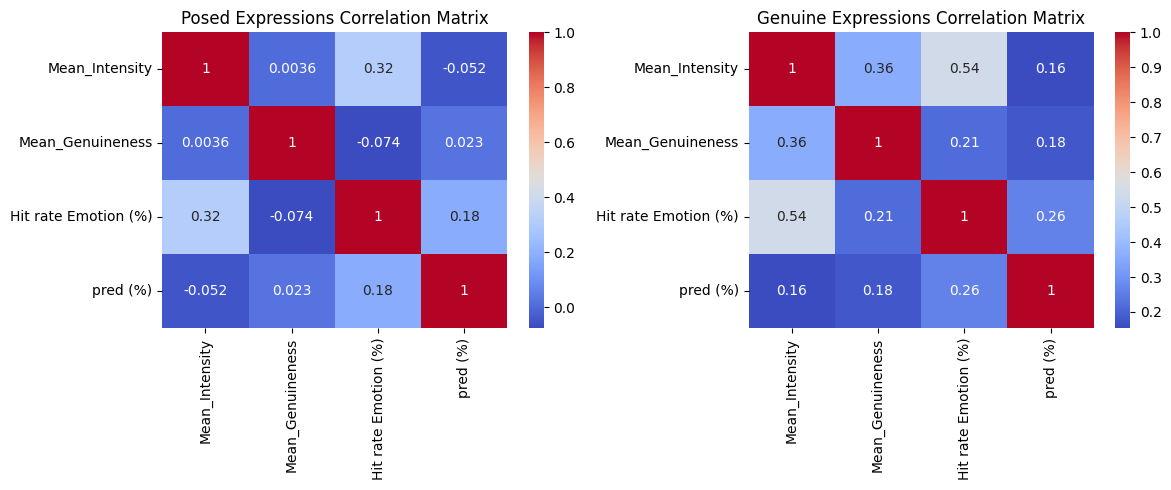

In [8]:
# Set the size of the plots
plt.figure(figsize=(12, 5))

# Plot for posed correlations
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.heatmap(corr_1, annot=True, cmap='coolwarm')
plt.title("Posed Expressions Correlation Matrix")

# Plot for genuine correlations
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.heatmap(corr_2, annot=True, cmap='coolwarm')
plt.title("Genuine Expressions Correlation Matrix")

plt.tight_layout()
plt.show()

## ANOVA (Type II)
- Dependent variable: Emotion Classifcation confident mean(%)
- Independent variables: 'Mean_Intensity', 'Mean_Genuineness', and 'Hit rate Emotion (%)'

In [9]:
# Dependent variable = 'pred (%)'
# Independent variables: 'Mean_Intensity', 'Mean_Genuineness', and 'Hit rate Emotion' as 
model_formula_full = 'Q("pred (%)") ~ Mean_Intensity + Mean_Genuineness + Q("Hit rate Emotion (%)")'

# Fit the ANOVA model
model_full = ols(model_formula_full, data=merged_data).fit()

# Type II ANOVA
anova_results_full = sm.stats.anova_lm(model_full, typ=2)

# print ANOVA table
print(anova_results_full)

                              sum_sq      df          F        PR(>F)
Mean_Intensity              0.139040     1.0   3.758497  5.273335e-02
Mean_Genuineness            0.511769     1.0  13.833991  2.072959e-04
Q("Hit rate Emotion (%)")   2.784032     1.0  75.257086  1.087738e-17
Residual                   53.714744  1452.0        NaN           NaN


 - **Sum of squares**: 
   - amount of variance in the dependent variable explained by each factor
 - **Degrees of Freedom**: 
   - the number of independent values in a data set that are free to vary. 
   - 1 df means they are continuous variables.
 - **F-statistic**: 
   - the result of a ratio of two variances: the variance explained by the factor (between-group variance) divided by the unexplained variance. It helps determine if the means across different groups are significantly different.
   - A high F-value indicates that there is more variation between groups than within groups, suggesting that the factor has a significant effect on the dependent variable. 
 - **P-value**: 
   - the probability of obtaining a result at least as extreme as the one observed, assuming that the null hypothesis (of no effect) is true. Assess the significance of the results.
   - A low p-value (less than 0.05) suggests that the observed data are unlikely under the null hypothesis and thus provides evidence against the null hypothesis. 

## Cnnfusion Matrix

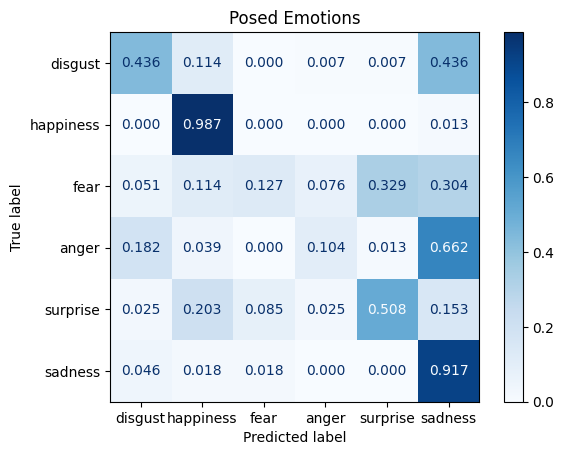

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'posed_data' is a DataFrame with 'Emotion' and 'predicted_emotion' columns
actual_emotions = posed_data['Emotion']
predicted_emotions = posed_data['predicted_emotion']

# Compute the normalized confusion matrix
cm = confusion_matrix(actual_emotions, predicted_emotions, labels=actual_emotions.unique(), normalize='true')

# Create the confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actual_emotions.unique())

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.3f')  # Format values to 3 decimal places
ax.set_title('Posed Emotions')
plt.show()


Posed Emotions [[0.43571429 0.11428571 0.         0.00714286 0.00714286 0.43571429]
 [0.         0.98709677 0.         0.         0.         0.01290323]
 [0.05063291 0.11392405 0.12658228 0.07594937 0.32911392 0.30379747]
 [0.18181818 0.03896104 0.         0.1038961  0.01298701 0.66233766]
 [0.02542373 0.20338983 0.08474576 0.02542373 0.50847458 0.15254237]
 [0.04587156 0.01834862 0.01834862 0.         0.         0.91743119]]
Genuine Emotions [[0.25170068 0.21088435 0.00680272 0.01360544 0.         0.5170068 ]
 [0.01869159 0.92990654 0.         0.0046729  0.01401869 0.03271028]
 [0.04255319 0.31914894 0.04255319 0.04255319 0.12765957 0.42553191]
 [0.11864407 0.06779661 0.         0.18644068 0.10169492 0.52542373]
 [0.03278689 0.3442623  0.08196721 0.         0.24590164 0.29508197]
 [0.04395604 0.08791209 0.         0.         0.01098901 0.85714286]]
['disgust' 'happiness' 'fear' 'anger' 'surprise' 'sadness']


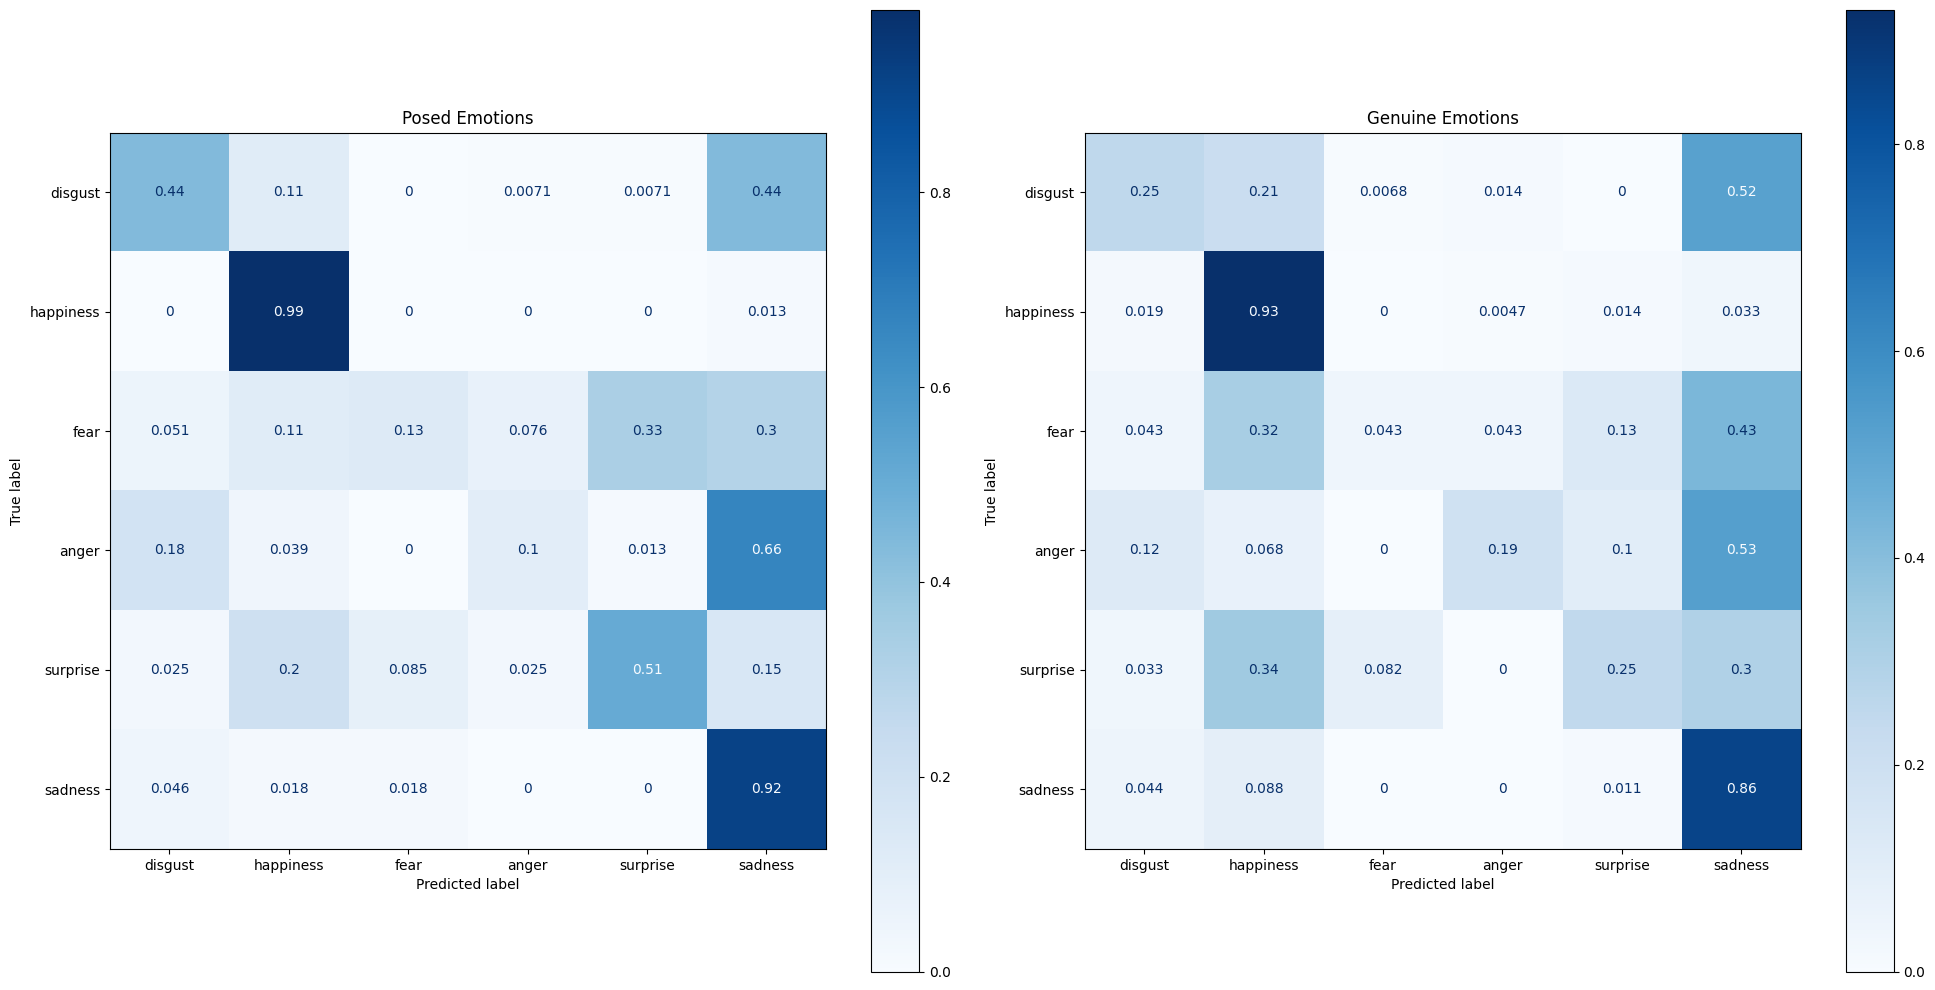

In [11]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot confusion matrix for posed_data
actual_emotions = posed_data['Emotion']
predicted_emotions = posed_data['predicted_emotion']
cm1 = confusion_matrix(actual_emotions, predicted_emotions, labels=actual_emotions.unique(), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=actual_emotions.unique())
disp.plot(cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Posed Emotions')

# Plot confusion matrix for genuine_data
actual_emotions = genuine_data['Emotion']
predicted_emotions = genuine_data['predicted_emotion']
cm2 = confusion_matrix(actual_emotions, predicted_emotions, labels=actual_emotions.unique(), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=actual_emotions.unique())
disp.plot(cmap=plt.cm.Blues, ax=ax2)
ax2.set_title('Genuine Emotions')

# raw data
print('Posed Emotions',cm1)
print('Genuine Emotions',cm2)
print(actual_emotions.unique())
plt.tight_layout()
plt.show()



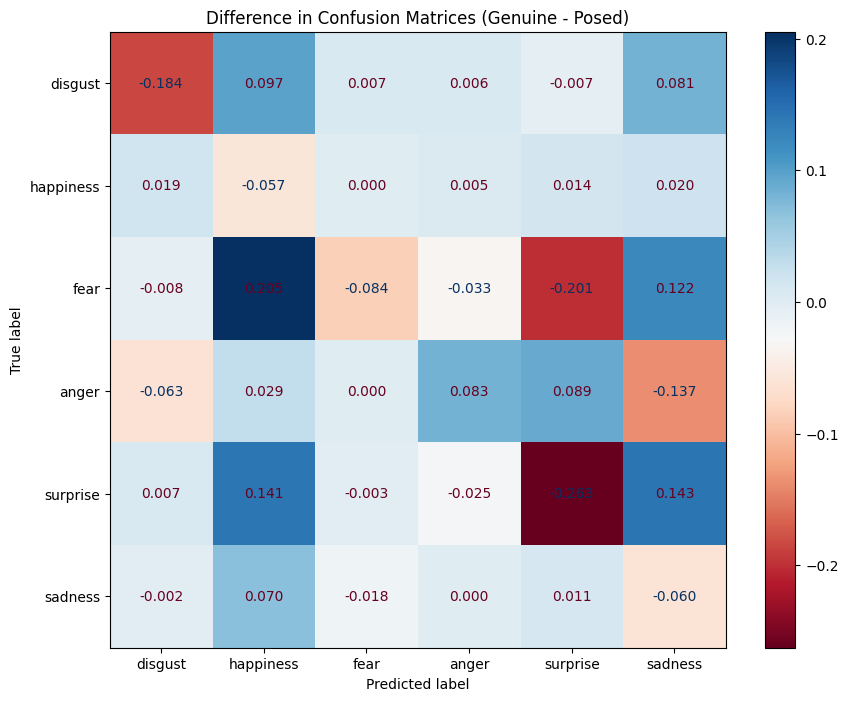

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
cm_diff = cm2-cm1
ConfusionMatrixDisplay(cm_diff, display_labels=labels).plot(cmap=plt.cm.RdBu, ax=ax, values_format='.3f')

ax.set_title('Difference in Confusion Matrices (Genuine - Posed)')
plt.show()